# Paleopandas Playground

The goal of this notebook is to explore the uses of pandas within Pyleoclim, particularly since the implementation of non-nanosecond time resolutions that allow for geological and cosmological time scales to be represented within NumPy/Pandas (references needed)

In [1]:
%load_ext autoreload
%load_ext watermark
%autoreload 2

import pandas as pd
import pyleoclim as pyleo
import datetime
import numpy

## Series creation:

A new feature is that Pyleoclim ships with a few pre-defined datasets

In [2]:
pyleo.utils.available_dataset_names()

['SOI', 'NINO3', 'HadCRUT5', 'AIR', 'LR04', 'AACO2', 'GISP2']

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='time [year C.E.]', ylabel='SOI [mb]'>)

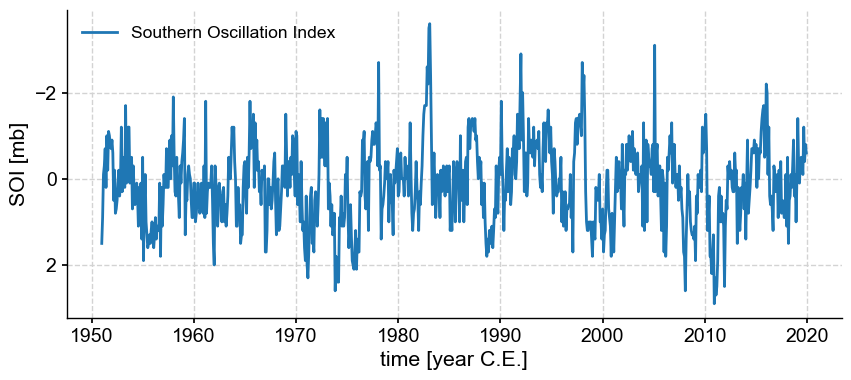

In [3]:
ts = pyleo.utils.load_dataset('SOI')
ts.plot(invert_yaxis=True)

New properties attached to `pyleo.Series` objects:
1. a pandas datetime_index:

In [4]:
ts.datetime_index

DatetimeIndex(['1950-12-31 12:42:56', '1951-01-30 23:11:49',
               '1951-03-02 09:41:14', '1951-04-01 20:10:07',
               '1951-05-02 06:39:01', '1951-06-01 17:08:26',
               '1951-07-02 03:37:19', '1951-08-01 14:06:12',
               '1951-09-01 00:35:37', '1951-10-01 11:04:30',
               ...
               '2019-03-01 20:57:20', '2019-04-01 07:26:14',
               '2019-05-01 17:55:07', '2019-06-01 04:24:32',
               '2019-07-01 14:53:25', '2019-08-01 01:22:19',
               '2019-08-31 11:51:43', '2019-09-30 22:20:37',
               '2019-10-31 08:49:30', '2019-11-30 19:18:55'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

2. a dictionary bundling all the metadata:

In [5]:
ts.metadata

{'time_unit': 'year C.E.',
 'time_name': 'time',
 'value_unit': 'mb',
 'value_name': 'SOI',
 'label': 'Southern Oscillation Index',
 'lat': None,
 'lon': None,
 'archiveType': 'Instrumental',
 'importedFrom': None,
 'log': None}

When invoking the object itself, the `__repr__` method is called, showing some essential metadata and a compressed view of the data:   

In [6]:
ts

{'archiveType': 'Instrumental', 'label': 'Southern Oscillation Index'}


None
time [year C.E.]
1951.000000    1.5
1951.083333    0.9
1951.166667   -0.1
1951.250000   -0.3
1951.333333   -0.7
              ... 
2019.583333   -0.1
2019.666667   -1.2
2019.750000   -0.4
2019.833333   -0.8
2019.916667   -0.6
Name: SOI [mb], Length: 828, dtype: float64

For a prettier display (in Jupyter notebook only):

In [7]:
ts.view()

,SOI [mb]
time [year C.E.],
1951.000000,1.5
1951.083333,0.9
1951.166667,-0.1
1951.250000,-0.3
1951.333333,-0.7
...,...
2019.583333,-0.1
2019.666667,-1.2
2019.750000,-0.4


## to_pandas()

one can export from pyleo.Series to a pandas Series:

In [8]:
pdts = ts.to_pandas() #  returns just the Series ; metadata are available at ts.metadata
type(pdts) 

pandas.core.series.Series

It is now a bona fide Pandas series, and we can do with it everything we might do with pandas, like:

In [9]:
pdts.head()

datetime
1950-12-31 12:42:56    1.5
1951-01-30 23:11:49    0.9
1951-03-02 09:41:14   -0.1
1951-04-01 20:10:07   -0.3
1951-05-02 06:39:01   -0.7
Name: SOI, dtype: float64

Or this:

In [10]:
pdts.describe()

count    828.000000
mean       0.119928
std        0.938586
min       -3.600000
25%       -0.500000
50%        0.100000
75%        0.800000
max        2.900000
Name: SOI, dtype: float64

Because Pyleoclim now has pandas under the hood, one can now apply any pandas method to a pyleoclim Series, via a [lambda function](https://www.freecodecamp.org/news/python-lambda-function-explained/). For instance, applying a transform to the data:

In [11]:
import numpy as np
ts.pandas_method(lambda x: x.transform(np.exp))

{'archiveType': 'Instrumental', 'label': 'Southern Oscillation Index'}


None
time [year C.E.]
1951.000000    4.481689
1951.083333    2.459603
1951.166667    0.904837
1951.250000    0.740818
1951.333333    0.496585
                 ...   
2019.583333    0.904837
2019.666667    0.301194
2019.750000    0.670320
2019.833333    0.449329
2019.916667    0.548812
Name: SOI [mb], Length: 828, dtype: float64

The new `resample()` function leverages the `pandas` function of the same name, but also understands paleo semantics.  For instances, let's load the LR04 dataset and resample it at 5kyr intervals. 

<AxesSubplot: xlabel='Age [ky BP]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>

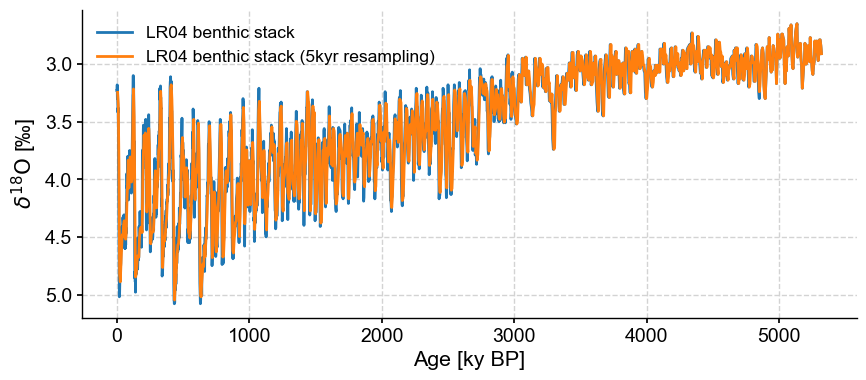

In [12]:
lr04 = pyleo.utils.load_dataset('LR04')
lr04_5kavg = lr04.resample('5kyr').mean()
fig, ax = lr04.plot(invert_yaxis=True)
lr04_5kavg.plot(ax=ax,color='C1')   

## TODO: wait for issue 361 to be resolved

Same same would work by specifying 'ka', 'ky', or 'kyrs' as units. In fact, tall those would work:

In [13]:
pyleo.utils.tsbase.MATCH_KA

frozenset({'ka', 'kiloyear', 'kiloyr', 'kiloyrs', 'ky', 'kyr', 'kyrs'})

For millions of years, use those:

In [14]:
pyleo.utils.tsbase.MATCH_MA

frozenset({'ma', 'my', 'myr', 'myrs'})

and so on for other multiples, like years (`pyleo.utils.tsbase.MATCH_A`) or billion years (`pyleo.utils.tsbase.MATCH_GA`) 


## Unit conversions

This semantics enables enhanced conversions betwen time representations:

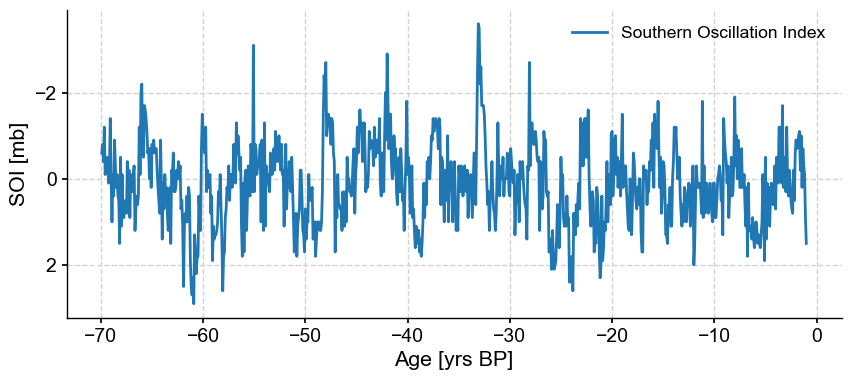

In [15]:
tsBP = ts.convert_time_unit('yrs BP', keep_log = True)  # BUG: converted to descending values
fig, ax = tsBP.plot(invert_yaxis=True) # by default, plots represent values in increasing order, so we reverse the x-axis

In [16]:
tsBP

{'archiveType': 'Instrumental',
 'label': 'Southern Oscillation Index',
 'log': ({0: 'convert_time_unit', 'time_unit': 'yrs BP'},)}


None
Age [yrs BP]
-69.914717   -0.6
-69.831383   -0.8
-69.748050   -0.4
-69.664717   -1.2
-69.581383   -0.1
             ... 
-1.331383    -0.7
-1.248050    -0.3
-1.164717    -0.1
-1.081383     0.9
-0.998050     1.5
Name: SOI [mb], Length: 828, dtype: float64

The series now plots from recent to old, because the Matplotlib `plot()` function always works with increasing values. The index has been flipped as well:

In [17]:
tsBP.datetime_index

DatetimeIndex(['2019-11-30 19:18:55', '2019-10-31 08:49:30',
               '2019-09-30 22:20:37', '2019-08-31 11:51:43',
               '2019-08-01 01:22:19', '2019-07-01 14:53:25',
               '2019-06-01 04:24:32', '2019-05-01 17:55:07',
               '2019-04-01 07:26:14', '2019-03-01 20:57:20',
               ...
               '1951-10-01 11:04:30', '1951-09-01 00:35:37',
               '1951-08-01 14:06:12', '1951-07-02 03:37:19',
               '1951-06-01 17:08:26', '1951-05-02 06:39:01',
               '1951-04-01 20:10:07', '1951-03-02 09:41:14',
               '1951-01-30 23:11:49', '1950-12-31 12:42:56'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

If we wanted to preserve the original time flow (old to recent) in a plot, all you'd have to do is use the `invert_xaxis` parameter:

<AxesSubplot: xlabel='time [year C.E.]', ylabel='SOI [mb]'>

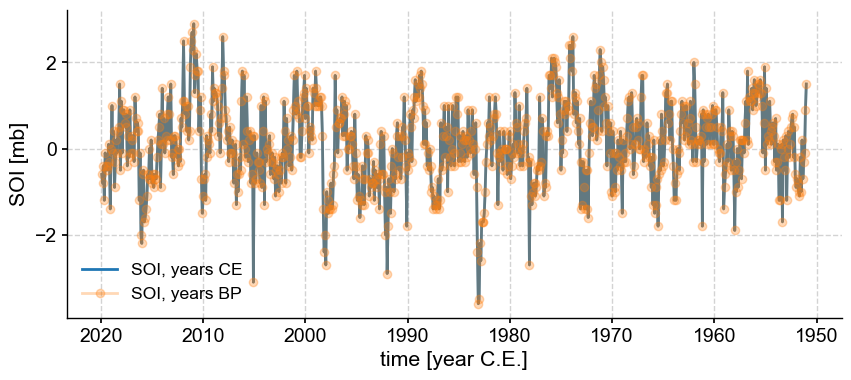

In [18]:
fig, ax = ts.plot(invert_yaxis=True, label='SOI, years CE') 
ts.plot(invert_yaxis=True, invert_xaxis=True, label = 'SOI, years BP',
        ax = ax, marker='o',color='C1',alpha = 0.3) 

## Irregularly sampled series

Let us make sure that pandas' abilities are not thrown off by irregular spacing

In [19]:
path = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(path, skiprows=137, sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

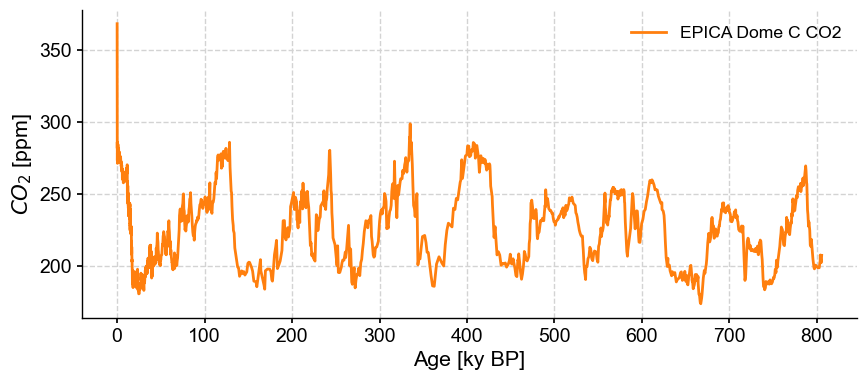

In [20]:
co2ts = pyleo.utils.load_dataset('AACO2')
co2ts.plot(color='C1')

In [21]:
co2ts.view()

,$CO_2$ [ppm]
Age [ky BP],
-0.05103,368.02
-0.04800,361.78
-0.04628,359.65
-0.04441,357.11
-0.04308,353.95
...,...
803.92528,202.92
804.00987,207.50
804.52267,204.86


To select a particular interval, (say the [Eemian](https://en.wikipedia.org/wiki/Eemian), 115 to 130 ky BP), you can use `sel`:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

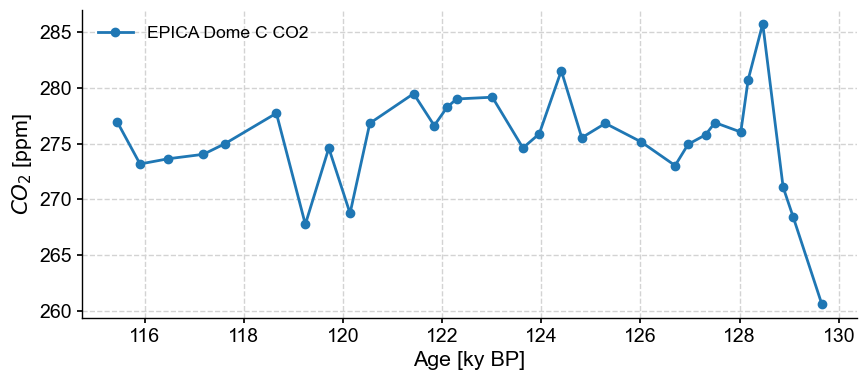

In [22]:
co2_ee = co2ts.sel(time=slice(115,130))
co2_ee.plot(marker='o')

If you wanted to extract the time of the maximum value, an easy approach is to use `sel` again, this time filtering on values 282ppm and above:

In [23]:
co2_ee.sel(value=slice(282,None))

{'archiveType': 'Glacier Ice',
 'importedFrom': 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt',
 'label': 'EPICA Dome C CO2'}


None
Age [ky BP]
128.46673    285.76
Name: $CO_2$ [ppm], dtype: float64

This way, we zero-ed in on the value 128.5 ky BP as the highest $CO_2$ concentration in the Eemian. 

Similarly, to identify the timing of interglacials by values below 200 ppm, one could do:

<AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

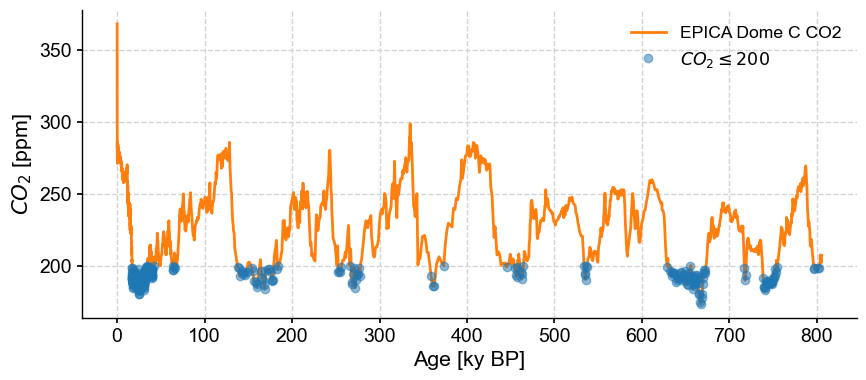

In [24]:
co2_IG = co2ts.sel(value=slice(None,200)) # returns a new Series object
fig, ax = co2ts.plot(color='C1')
co2_IG.plot(marker='o',linewidth=0,alpha= 0.5, ax=ax,label=r"$CO_2\leq200$") 

## CSV Import/Export

### to CSV

In [25]:
co2ts.to_csv(path='../data')

Series exported to ../data/EPICA_Dome_C_CO2.csv


### from CSV
One should be able to read the file back in and get the same result:

In [26]:
co2ts2 = pyleo.Series.from_csv(filename='../data/EPICA_Dome_C_CO2.csv')
co2ts2.equals(co2ts) # showcasing the use of the 'equals' method

Time axis values sorted in ascending order


(True, True)

## Resampling

Let's use [resample()](https://pandas.pydata.org/docs/user_guide/timeseries.html#resampling) to coarse-grain on 5,000 year intervals. Notice how you can use normal "paleo-speak" for that:

In [27]:
co2_5k = co2ts.resample('5ka')
type(co2_5k)

pyleoclim.core.series.SeriesResampler

The output of this function is a variant on a pandas [resampler](https://pandas.pydata.org/docs/reference/resampling.html); the values then need to be aggregated or transformed. Let's average them over those 5y bins:

<AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

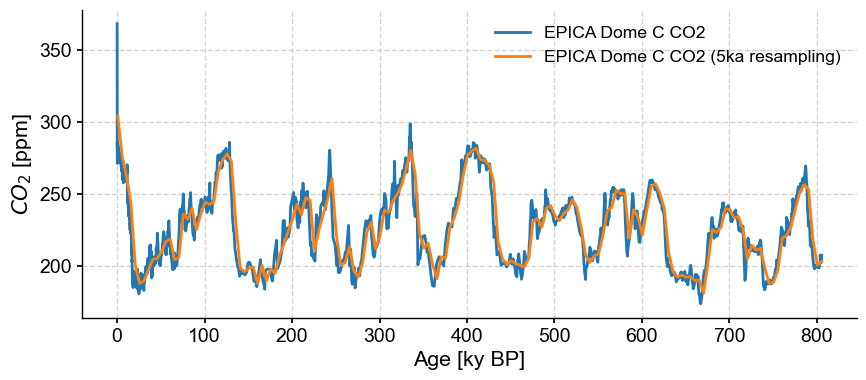

In [28]:
co2_5kavg = co2_5k.mean()
fig, ax = co2ts.plot()
co2_5kavg.plot(ax=ax,color='C1')         

Though we could choose other statistics, like a running standard deviation:

In [29]:
co2_5k.std().view()

,$CO_2$ [ppm]
Age [ky BP],
0.668997,21.187646
5.669003,4.424875
10.669005,2.471905
15.669011,12.374541
20.669014,13.381836
...,...
785.669646,3.247548
790.669649,15.221735
795.669654,8.006723


## TODO
update when [issue 361](https://github.com/LinkedEarth/Pyleoclim_util/issues/361) is resolved 

## Creating and manipulating MultipleSeries objects

Here we showcase new shorthands to easily create and manipulate MultipleSeries objects. 

First, let's load another dataset with a time axis that has some overlap with the EPICA DOME C $CO_2$ record:

In [30]:
gisp2 = pyleo.utils.load_dataset('GISP2')

We then create a `MultipleSeries` object using the `&` shorthand:

In [31]:
ms = lr04.flip() & gisp2
type(ms)

pyleoclim.core.multipleseries.MultipleSeries

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='value'>)

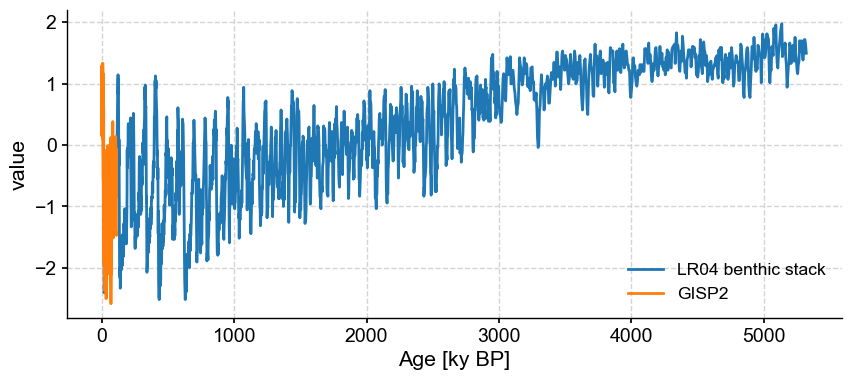

In [32]:
ms.standardize().plot()  

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='$\\delta^{18} \\mathrm{O}$ x (-1) [‰]'>,
  1: <Axes: ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>,
  2: <Axes: xlabel='Age [ky BP]'>})

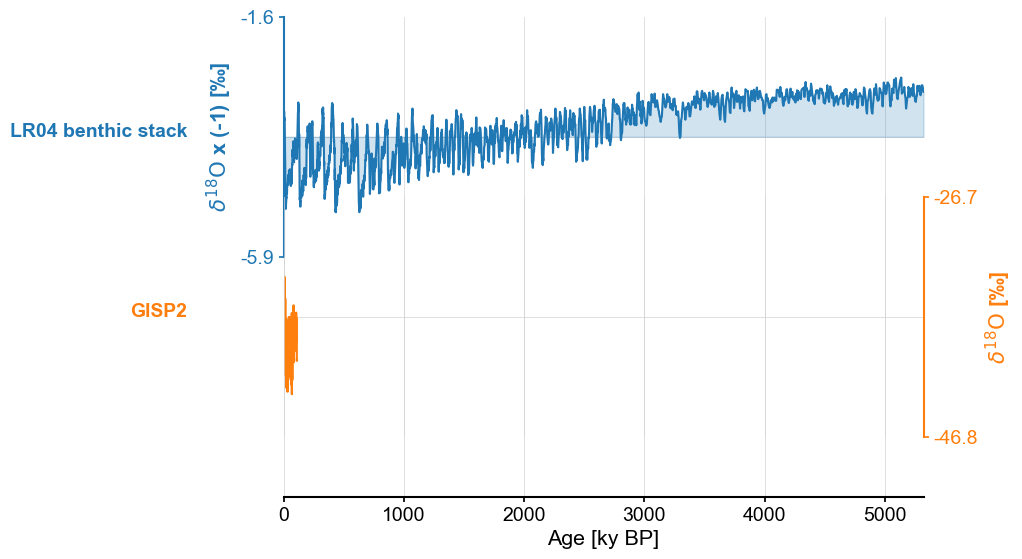

In [33]:
ms.stackplot()

### Adding a series to a MultipleSeries object:

this can now be done with the "+" operator, which is understood to mean: "add this Series to the existing MultipleSeries object. The method will confirm that you are not adding a series that is already in the MultipleSeries object by comparing it to the contents of the object, pairwise:

The two series have different lengths, left: 2115 vs right: 1901
Metadata are different:
value_unit property -- left: ‰, right: ppm
value_name property -- left: $\delta^{18} \mathrm{O}$ x (-1), right: $CO_2$
label property -- left: LR04 benthic stack, right: EPICA Dome C CO2
lat property -- left: None, right: -75.1011
lon property -- left: None, right: 123.3478
archiveType property -- left: Marine Sediment, right: Glacier Ice
importedFrom property -- left: None, right: https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt
The two series have different lengths, left: 1390 vs right: 1901
Metadata are different:
time_unit property -- left: yr BP, right: ky BP
value_unit property -- left: ‰, right: ppm
value_name property -- left: $\delta^{18} \mathrm{O}$, right: $CO_2$
label property -- left: GISP2, right: EPICA Dome C CO2
lat property -- left: 72.6, right: -75.1011
lon property -- left: 398.5, right: 123.3478
importedFrom property -- left: https://www

(0.0, 1000.0)

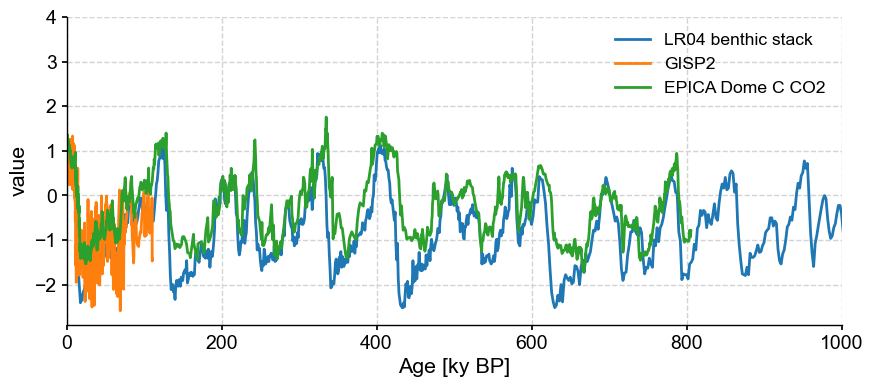

In [34]:
ms3 = ms + co2ts 
fig, ax = ms3.standardize().plot()
ax.set_xlim([0, 1000]) # plot only over the past 1 Ma

The advantages of this shorthand are slim when dealing with just two Series, but it is beneficial when recursively adding Series object to a MultipleSeries object (e.g. in a loop)

**TODO** add Euro2k example when pyLip is operational (JEG)

### Adding two MultipleSeries objects together:

Suppose now I want to add ms and ms2 together. Both have a Series in common, which need to be dealt with to avoid redundancy:

In [36]:
mst = ms + ms2

The two series have values differing by more than 1e-05 ‰
Metadata are different:
value_name property -- left: $\delta^{18} \mathrm{O}$ x (-1), right: $\delta^{18} \mathrm{O}$
The two series have different lengths, left: 1390 vs right: 2115
Metadata are different:
time_unit property -- left: yr BP, right: ky BP
label property -- left: GISP2, right: LR04 benthic stack
lat property -- left: 72.6, right: None
lon property -- left: 398.5, right: None
archiveType property -- left: Glacier Ice, right: Marine Sediment
importedFrom property -- left: https://www.ncei.noaa.gov/access/paleo-search/study/17796, right: None
The two series have different lengths, left: 2115 vs right: 1901
Metadata are different:
value_unit property -- left: ‰, right: ppm
value_name property -- left: $\delta^{18} \mathrm{O}$ x (-1), right: $CO_2$
label property -- left: LR04 benthic stack, right: EPICA Dome C CO2
lat property -- left: None, right: -75.1011
lon property -- left: None, right: 123.3478
archiveType prope

(<Figure size 640x480 with 5 Axes>,
 {0: <Axes: ylabel='$\\delta^{18} \\mathrm{O}$ x (-1) [‰]'>,
  1: <Axes: ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>,
  2: <Axes: ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>,
  3: <Axes: ylabel='$CO_2$ [ppm]'>,
  4: <Axes: xlabel='Age [ky BP]'>})

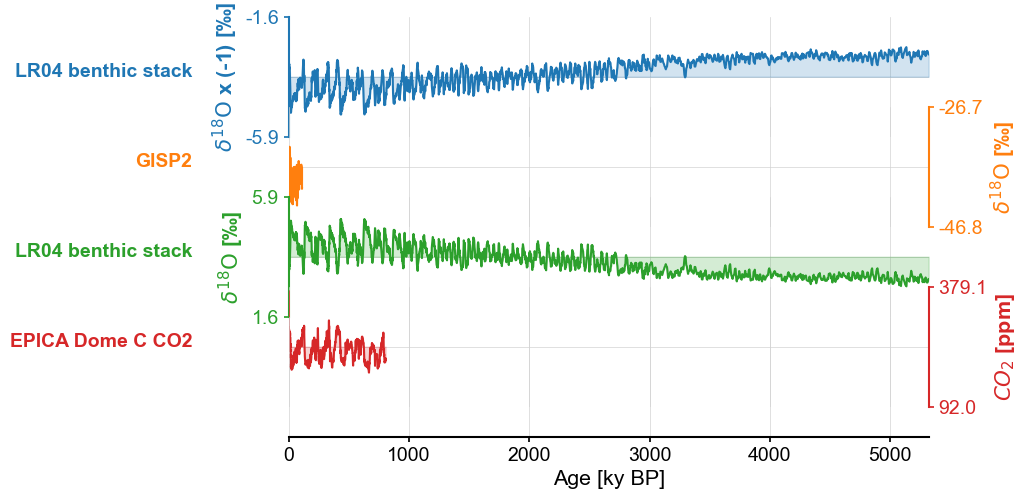

In [37]:
mst.stackplot()

### Removing a series from a MultipleSeries object:

the "-" sign can be used to remove a series (identified by its label) from a MultipleSeries collection. Note that the object is modified "in place", not exported to another variable:

In [38]:
ms3 - lr04.label
print([ts.label for ts in ms3.series_list])

['GISP2', 'EPICA Dome C CO2']


### Exporting to pandas

The `MultipleSeries` class also has a `to_pandas()` method; this one exports to a dataframe:

In [39]:
df = ms3.to_pandas()
df.head()

,GISP2,EPICA Dome C CO2
datetime,,
-803719-10-17 10:22:57,NaN,207.29
-803182-03-23 07:19:38,NaN,202.23
-802573-12-30 00:58:49,NaN,204.86
-802060-10-17 05:46:09,NaN,207.50
-801975-05-20 01:52:17,NaN,202.92


In [40]:
df.to_csv('../data/export_df.csv')

Some plotting functions work out of the proverbial box:

array([[<AxesSubplot: title={'center': 'GISP2'}>,
        <AxesSubplot: title={'center': 'EPICA Dome C CO2'}>]],
      dtype=object)

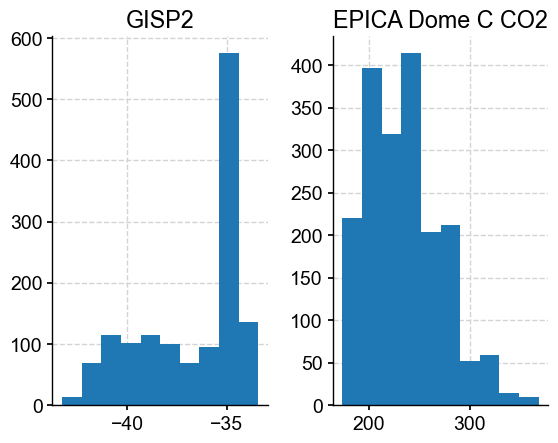

In [41]:
df.hist()

Alas, `df.plot()` wouldn't work, as Matplotlib assumes dates must be between year 0001 and 9999. 

In [42]:
%watermark -n -u -v -iv -w

Last updated: Fri Mar 24 2023

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

pandas   : 2.0.0.dev0+1541.gf3d4113052
numpy    : 1.23.5
pyleoclim: 1.0.0b0

Watermark: 2.3.1

